# 从头开始搭建神经网络和训练神经网络

## step1-搜集数据

In [18]:
import matplotlib
matplotlib.use('TkAgg')
# import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import  matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [20]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    print("X.shape", X.shape, "xx.ravel()", xx.ravel().shape, np.c_[xx.ravel(), yy.ravel()].shape)
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)

## step1 - 构建一个baseline模型


X.shape (200, 2) xx.ravel() (151208,) (151208, 2)


/Users/stellazhao/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Text(0.5, 1.0, 'Logistic Regression')

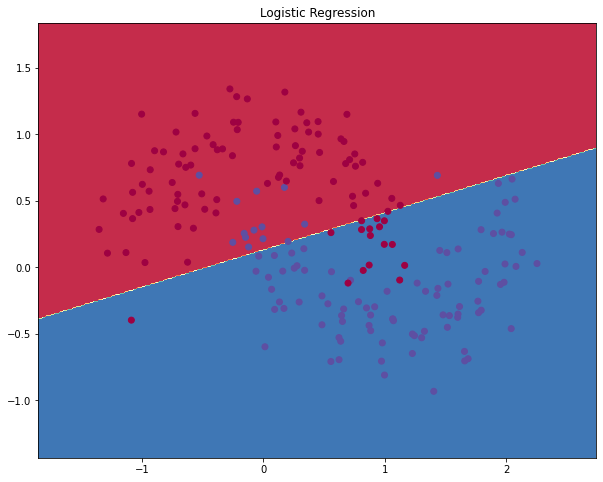

In [21]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, Y)

# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

这个图的横轴zhongzhou是x的两个特征，中间的斜线是逻辑回归算法从训练数据中学习到的决策边界。可以看到有一些样本被决策边界分到了错误的类别里面。

## step2 - 构造和训练一个神经网络

构造一个如下图所示的，两层的神经网络

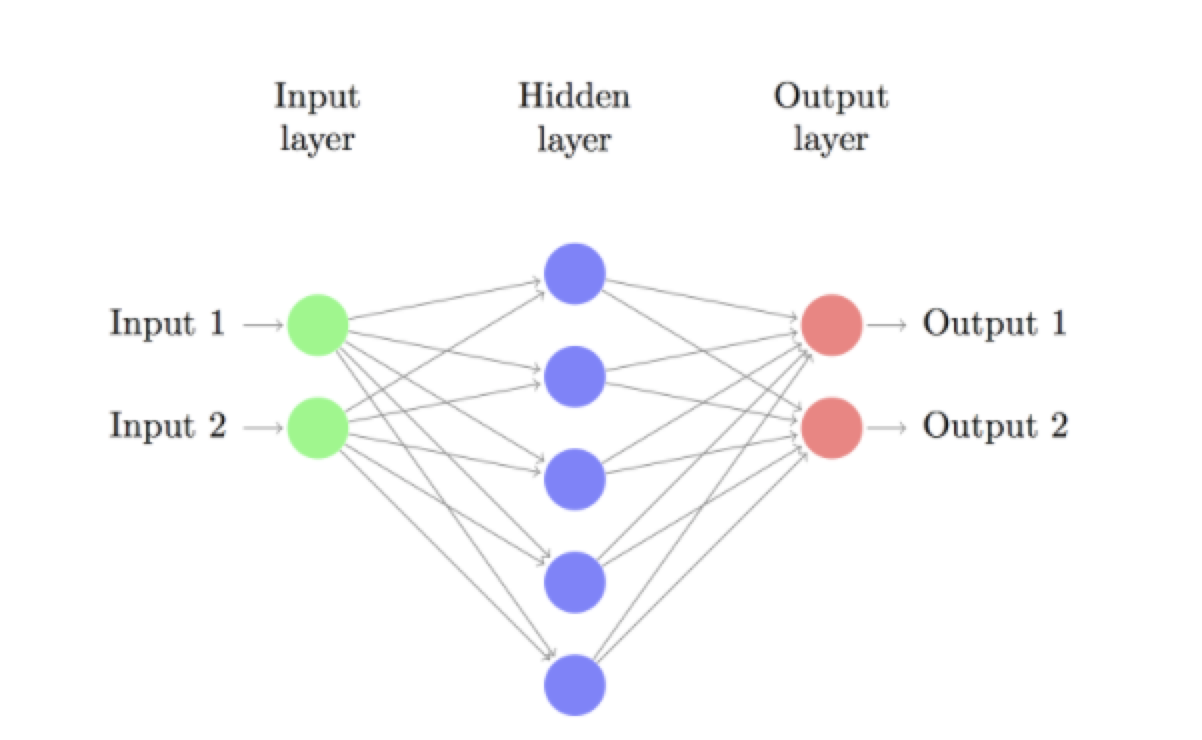

## 设置&初始化

In [35]:
# 0. 设置网络结构
hidden_units = 5
output_units = 1

# 1. 初始化权重向量
W1 = np.random.randn(hidden_units, m_features + 1) / np.sqrt(hidden_units)
W2 = np.random.randn(1, hidden_units + 1 ) / np.sqrt(hidden_units)
assert(W1.shape == (5, 3))
assert(W2.shape == (1, 6))


## 向前传播

In [36]:
X_full = np.concatenate((X, np.ones((n_samples, 1))), axis = 1)
assert(X_full.shape == (200, 3))
H = np.tanh(X_full.dot(W1.T))
assert(H.shape == (200, 5))

H_full = np.concatenate((H, np.ones((n_samples, 1))), axis = 1)
assert(H_full.shape == (200, 6))

logits = H_full.dot(W2.T)
assert(logits.shape == (200, 1))

probs = 1.0 / (1 + np.exp(logits))
assert(probs.shape == (200, 1))

loss = - Y * np.log(probs) - (1 - Y) * np.log(1 - probs)
print(loss.shape)
assert(loss.shape == (200, 1))

(200, 1)


## 向后传播

In [28]:
delta_logits = probs - Y 	
assert(delta_logits.shape == (200, 1))

delta_W2 =  np.dot(delta_logits.T, H_full)
assert(delta_W2.shape == (1, 6))

delta_H = np.dot(delta_logits, W2)
assert(delta_H.shape == (200, 6))

delta_a = delta_H[:, :-1] * ( 1 - H**2)
assert(delta_a.shape == (200, 5))

delta_W1 = np.dot(delta_a.T,  X_full)
assert(delta_W1.shape == (5, 3))

learning_rate = 0.02
W1 += delta_W1 * learning_rate
W2 += delta_W2 * learning_rate

https://stackoverflow.com/questions/42599498/numercially-stable-softmax/42606665#42606665

The softmax exp(x)/sum(exp(x)) is actually numerically well-behaved. It has only positive terms, so we needn't worry about loss of significance, and the denominator is at least as large as the numerator, so the result is guaranteed to fall between 0 and 1.

The only accident that might happen is over- or under-flow in the exponentials. Overflow of a single or underflow of all elements of x will render the output more or less useless.

But it is easy to guard against that by using the identity softmax(x) = softmax(x + c) which holds for any scalar c: Subtracting max(x) from x leaves a vector that has only non-positive entries, ruling out overflow and at least one element that is zero ruling out a vanishing denominator (underflow in some but not all entries is harmless).

Footnote: theoretically, catastrophic accidents in the sum are possible, but you'd need a ridiculous number of terms. For example, even using 16 bit floats which can only resolve 3 decimals---compared to 15 decimals of a "normal" 64 bit float---we'd need between 2^1431 (~6 x 10^431) and 2^1432 to get a sum that is off by a factor of two.

In [30]:

def train(X, Y , hidden_units, eps = 1e-15, n_epochs = 20000, learning_rate = 0.01):
    W1 = np.random.randn(hidden_units, m_features + 1) / np.sqrt(hidden_units)
    W2 = np.random.randn(2, hidden_units + 1 ) / np.sqrt(hidden_units)

    for epoch in range(n_epochs):
        [H, H_full, logits, probs] = foward(X, W1, W2)
        loss = - Y * np.log(probs) - (1 - Y) * np.log(1 - probs)
        [delta_W2, delta_W1] = backward(probs, Y, H_full, W2, H)
        W1 -= delta_W1 * learning_rate
        W2 -= delta_W2 * learning_rate
        if epoch % 5000 == 0:
            print("epoch={}, total_loss={}".format(epoch, sum(loss)))
    return W1, W2, probs


def foward(X, W1, W2):
    X_full = np.concatenate((X, np.ones((X.shape[0], 1))), axis = 1)
    H = np.tanh(X_full.dot(W1.T))
    H_full = np.concatenate((H, np.ones((X.shape[0], 1))), axis = 1)
    logits = H_full.dot(W2.T)
    probs = 1.0 / (1 + np.exp( - logits))
    probs[probs < 1e-15 ] = 1e-15
    probs[probs > 1 - 1e-15] =1 - 1e-15
    return H, H_full, logits, probs


def backward(probs, Y, H_full, W2, H):
    delta_logits = probs - Y 	
    delta_W2 =  np.dot(delta_logits.T, H_full)
    delta_H = np.dot(delta_logits, W2)
    delta_a = delta_H[:, :-1] * ( 1 - H**2)
    delta_W1 = np.dot(delta_a.T,  X_full)
    return delta_W2, delta_W1



整个训练过程串起来

epoch=0, total_loss=[166.16730956 135.83874777]
epoch=5000, total_loss=[14.52701909 14.52701853]
epoch=10000, total_loss=[14.51098464 14.51098462]
epoch=15000, total_loss=[14.43339512 14.43339512]
epoch=0, total_loss=[133.29088526 173.55509603]
epoch=5000, total_loss=[12.25266697 12.25559884]
epoch=10000, total_loss=[11.50113045 11.50136788]
epoch=15000, total_loss=[11.54597948 11.54601489]
epoch=0, total_loss=[147.52942838 173.59061181]
epoch=5000, total_loss=[4.8061797  4.80625039]
epoch=10000, total_loss=[4.08200697 4.08203133]
epoch=15000, total_loss=[3.67074869 3.67076115]
epoch=0, total_loss=[114.52382492 116.2667237 ]
epoch=5000, total_loss=[8.55864648 8.56272174]
epoch=10000, total_loss=[6.33942426 6.34006937]
epoch=15000, total_loss=[5.96050933 5.96047259]
epoch=0, total_loss=[171.27762551 211.72426694]
epoch=5000, total_loss=[5.28454296 5.29647119]
epoch=10000, total_loss=[3.26893179 3.27153056]
epoch=15000, total_loss=[2.25000991 2.25108724]
epoch=0, total_loss=[201.89411009

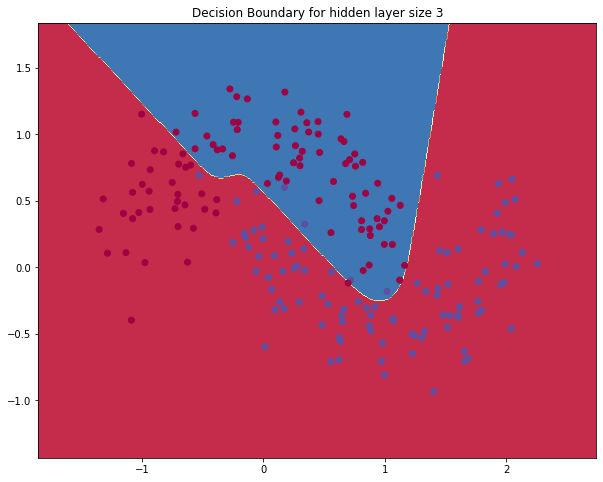

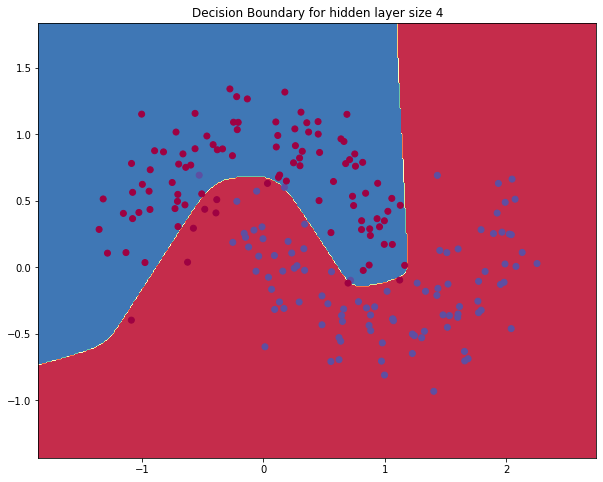

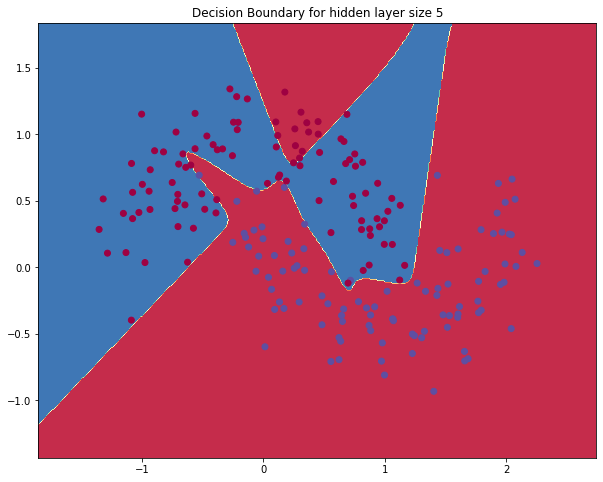

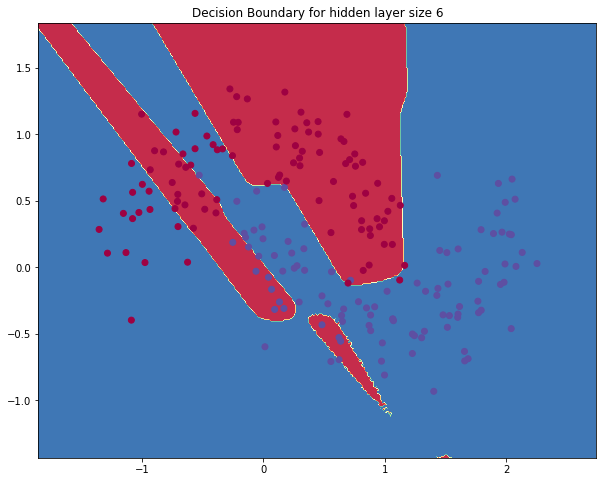

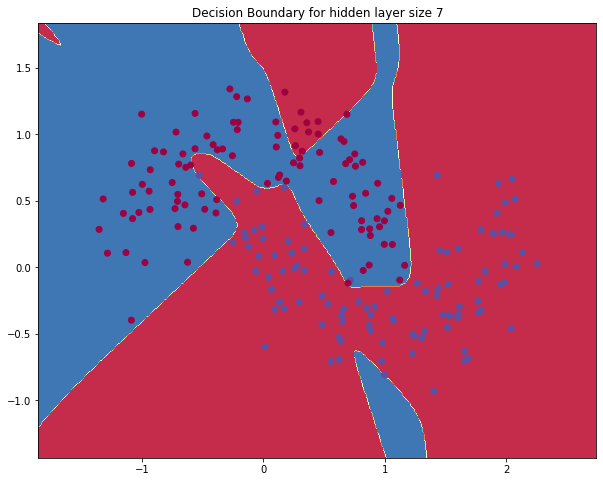

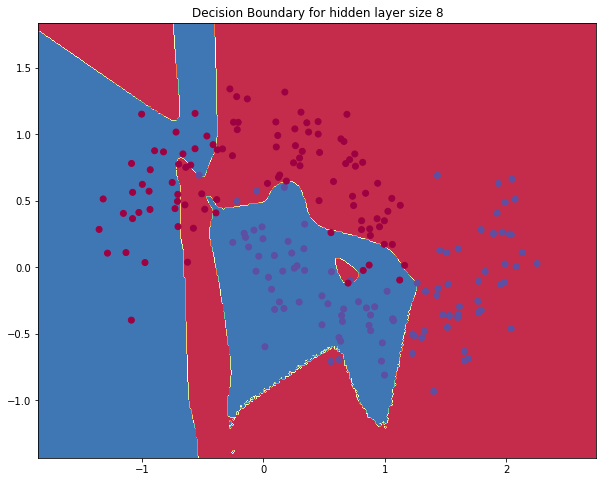

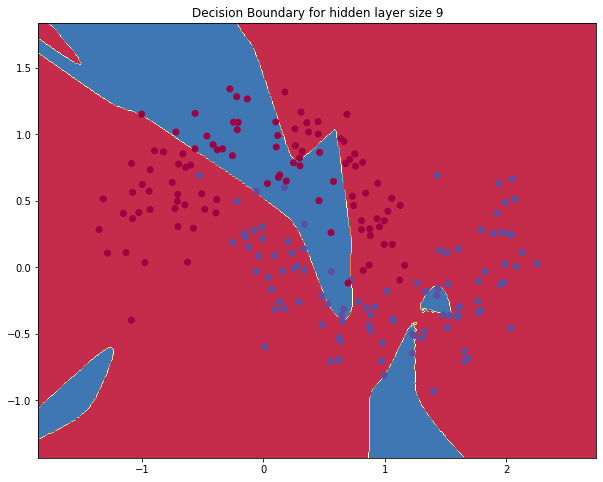

In [34]:
## 串起来
eps = 1e-15
n_epochs = 1
learning_rate = 0.01
for hidden_units in range(3,10):
    W1, W2, probs = train(X, Y , hidden_units=hidden_units, eps = 1e-15, n_epochs = 20000, learning_rate = 0.01)

    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    xx_yy = np.c_[xx.ravel(), yy.ravel()]
    [_, _, _, probs] = foward(xx_yy, W1, W2)
    Z = np.argmax(probs, axis=1).reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
    plt.title("Decision Boundary for hidden layer size {}".format(hidden_units))
    plt.show()


d_loss/d_prob = - 1 * label / prob

d_prob/d_logits = (1 - logits) * logits

d_logits/d_W2 = hidden_layer

d_hidden_layer / d_W1 = X

d_loss / d_W2 =  d_loss/d_prob * d_prob/d_logits * d_logits / d_W =  - 1 * label / prob *  (1 - logits) * logits * hidden_layer